Regression Pipeline
===================

This script demonstrates how to preprocess data and run an Optuna study to tune hyperparameters 
for a regression model. The features are sourced from 'media-4.xlsx' (using the sheet 'all features')
while the target values (viability) are loaded from 'secretome_samples_for_RNAseq_170111.xlsx'.

The viability target is a continuous variable, so we modify the pipeline as follows:
  - Load the target from a new Excel file and select the columns ['Gene name', 'Viability (harvest) [%]'].
  - Rename columns so that the gene names match the feature dataframe index and rename the viability column to “Viability”.
  - Remove any sampling or stratification (since the target is continuous).
  - In the Optuna objective, choose among regression models and use an appropriate metric (R²).

In [14]:
#############################
# Import Libraries & Modules
#############################

import json
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Data splitting and imputation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score

# ML models
from xgboost import XGBRegressor
import shap
import optuna
from sklearn.linear_model import Ridge

In [2]:
###########################
# Define Helper Functions
###########################

def show_heatmap(df, predictor_list, target='Viability', figsize=(20, 10), title='Correlation Heatmap'):
    # Create a correlation matrix (only numeric columns) and plot a heatmap
    correlation_matrix = df[predictor_list + [target]].corr(method='pearson')
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    plt.figure(figsize=figsize)
    plt.title(title)
    sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=0.5)
    plt.show()

def standardize_values(X):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(X)
    return scaler.transform(X)

def t_sne_plot(X, y, title='t-SNE plot'):
    from sklearn.manifold import TSNE
    X_tsne = TSNE(n_components=2, random_state=0).fit_transform(X)
    plt.figure(figsize=(10,10))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.5)
    plt.title(title)
    plt.colorbar(label='Viability')
    plt.show()

In [ ]:
###########################
# Load & Preprocess Features
###########################

# Read the features file (same as before)
df = pd.read_excel('data/media-4.xlsx', sheet_name='all features')

# Drop columns that are not needed and set the index
df = df.drop(columns=['sample_ID','uniprot_id'])
df.set_index('human_symbol', inplace=True)

# Group by index (to average out duplicates, if any)
df = df.groupby(df.index).mean()

# Visualize missing values
msno.bar(df, figsize=(12, 48), sort="ascending", fontsize=12, color='tomato')

# Drop columns with more than 50% missing values
threshold = 0.5
missing_percentage = df.isnull().mean()
columns_to_drop = missing_percentage[missing_percentage > threshold].index
df_dropped = df.drop(columns=columns_to_drop)

# Impute remaining missing values using KNNImputer
original_index = df_dropped.index
imputer = KNNImputer(n_neighbors=5)
df_imputed_array = imputer.fit_transform(df_dropped)
df_imputed = pd.DataFrame(df_imputed_array, columns=df_dropped.columns, index=original_index)

In [6]:
###############################
# Load & Preprocess the Target
###############################

# Read the new target file for regression (Cell Growth Ratio)
target_df = pd.read_excel('data/secretome_samples_for_RNAseq_170111.xlsx', sheet_name='all')

# Select only the relevant columns
target_df = target_df[['Gene name', 'Cell conc (transfection)', 'Cell conc (harvest)']]

# Compute Cell Growth Ratio
target_df['Cell Growth Ratio'] = target_df['Cell conc (harvest)'] / target_df['Cell conc (transfection)']

# Remove the original columns after computing the ratio
target_df = target_df.drop(columns=['Cell conc (transfection)', 'Cell conc (harvest)'])

# Rename columns so that the gene names match the features dataframe index
target_df = target_df.rename(columns={'Gene name': 'human_symbol'})

# Set the index to 'human_symbol'
target_df.set_index('human_symbol', inplace=True)

# Drop any rows with missing values in the target variable
target_df = target_df.dropna(subset=['Cell Growth Ratio'])

In [8]:
######################################
# Merge Features with the Regression Target
######################################

# Join the imputed features with the target Cell Growth Ratio values
df_merged = df_imputed.join(target_df, how='inner')
print("Merged data shape:", df_merged.shape)

Merged data shape: (76, 171)


Zero-variability columns: Index(['sequence_PSIM_GPI', 'sequence_PTM.detailed_Lipidation__GPI.anchor',
       'sequence_iPTMnet_Myristoylation', 'sequence_iPTMnet_S.Glycosylation'],
      dtype='object')
81 columns to drop due to high correlation: ['abundance_GTEx_Breast', 'abundance_GTEx_Cervix', 'abundance_GTEx_Colon', 'abundance_GTEx_Esophagus', 'abundance_GTEx_Heart', 'abundance_GTEx_Kidney', 'abundance_GTEx_Muscle', 'abundance_GTEx_Nerve', 'abundance_GTEx_Salivary', 'abundance_GTEx_Skin', 'abundance_GTEx_SmallIntestine', 'abundance_GTEx_fibroblasts', 'abundance_GTEx_max_GTEx_max', 'abundance_HPA.tissue.mean_HPA.protein.Level', 'abundance_RNA96_WT_tpm', 'abundance_cho_fpkm_pgsa_01', 'abundance_cho_fpkm_pgsa_02', 'abundance_cho_fpkm_pgsa_03', 'abundance_cho_fpkm_rna_day3', 'abundance_cho_fpkm_rna_day6', 'sequence_AA.comp_AA.comp_CHO_ratio_A', 'sequence_AA.comp_AA.comp_CHO_ratio_C', 'sequence_AA.comp_AA.comp_CHO_ratio_D', 'sequence_AA.comp_AA.comp_CHO_ratio_E', 'sequence_AA.comp_AA.co

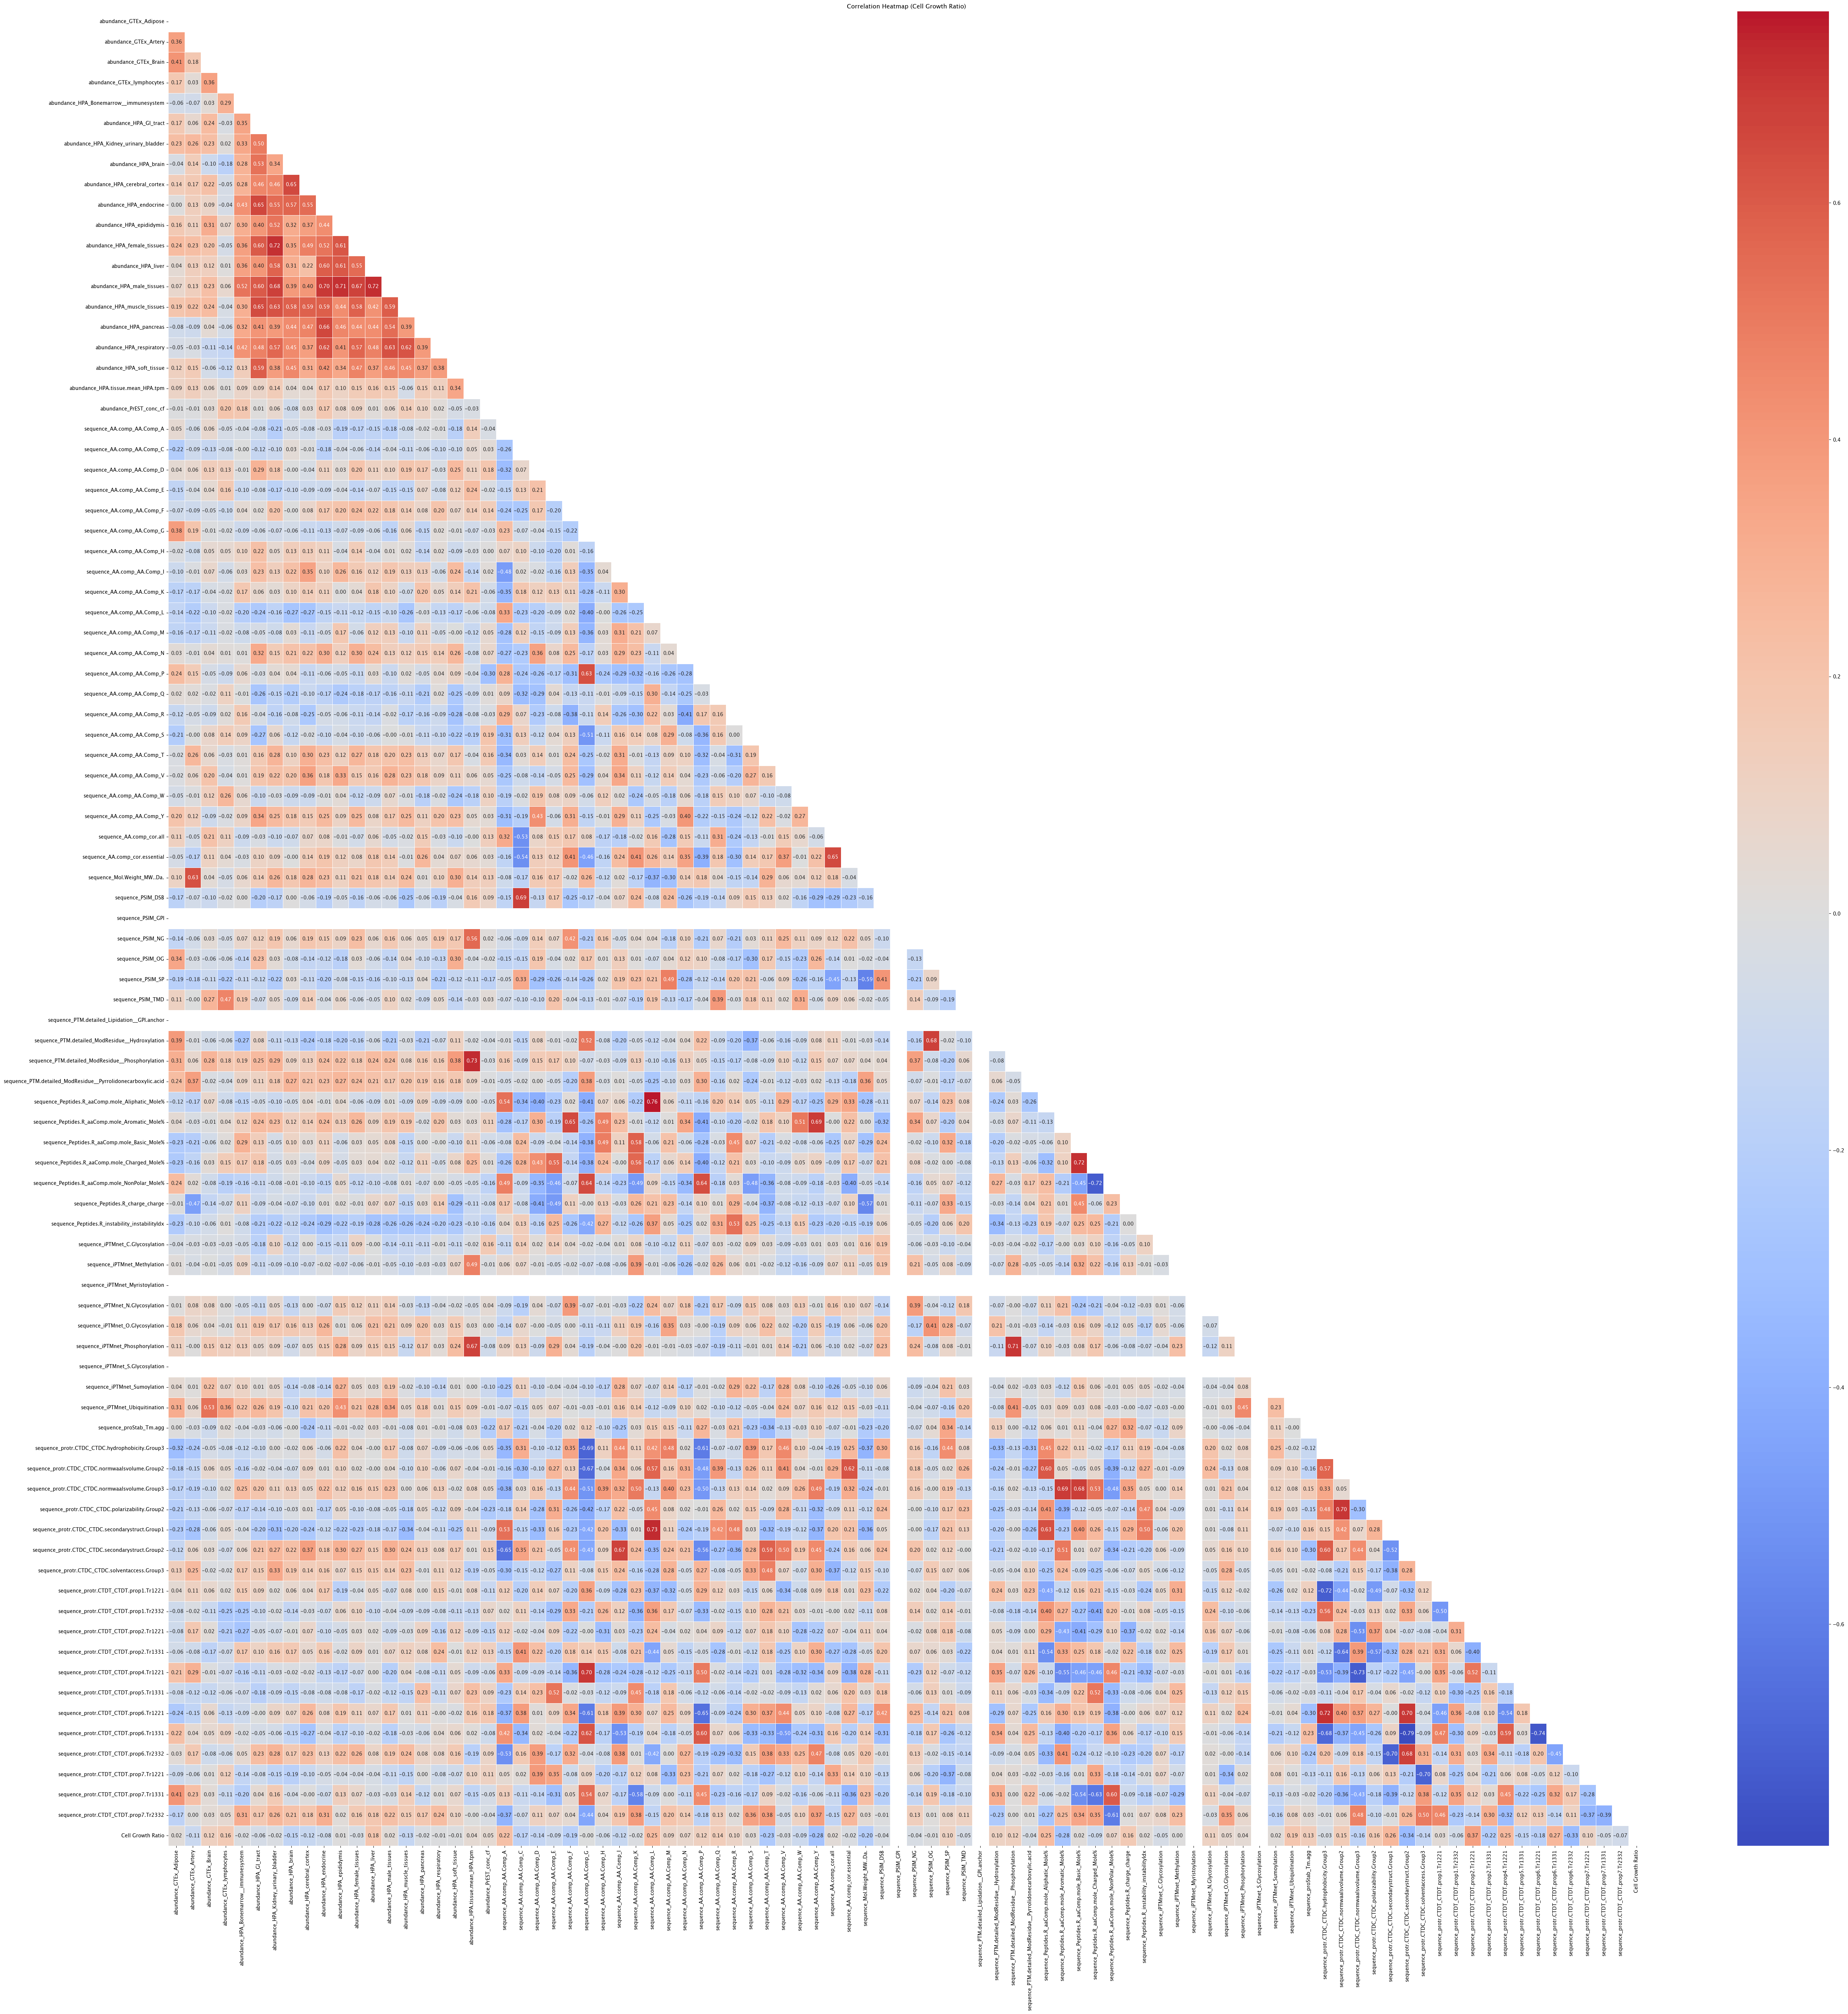

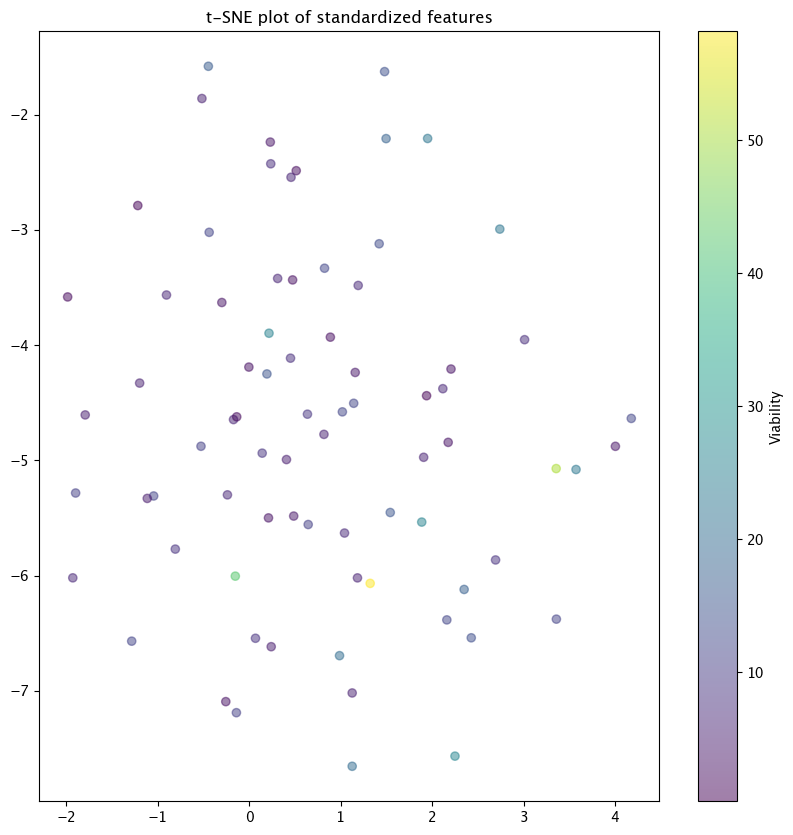

In [12]:
#############################################
# Explore Balance, Variability, and Correlations
#############################################

# Identify any columns with zero variability (if any)
zero_var_cols = df_merged.columns[df_merged.nunique() == 1]
print("Zero-variability columns:", zero_var_cols)

# Identify and drop highly correlated features (threshold = 0.80)
correlation_threshold = 0.80
correlation_matrix = df_merged.corr(method='pearson')
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(abs(upper[column]) > correlation_threshold)]
print(f'{len(to_drop)} columns to drop due to high correlation:', to_drop)

# Create a list of predictor columns by excluding the target and dropped columns
predictor_list = list(df_merged.columns)
predictor_list.remove('Cell Growth Ratio')  # Updated target variable name
predictor_list = [x for x in predictor_list if x not in to_drop]
print("Number of predictors:", len(predictor_list))

# Visualize correlations (features vs. Cell Growth Ratio)
show_heatmap(df=df_merged, target='Cell Growth Ratio', predictor_list=predictor_list, 
             title='Correlation Heatmap (Cell Growth Ratio)', figsize=(65,65))

# (Optional) Standardize values and explore with t-SNE
X_stand  = standardize_values(df_merged[predictor_list].values)
t_sne_plot(X_stand, df_merged['Cell Growth Ratio'].values, title='t-SNE plot of standardized features')

In [13]:
print(df_merged)

              abundance_GTEx_Adipose  abundance_GTEx_Artery  \
human_symbol                                                  
ACVR2A                       2.76400               1.470333   
ADIPOQ                     210.25000               3.091440   
ADM5                         7.45450               1.694233   
ALB                          0.55835               0.622333   
ANGPTL2                     65.91500              16.536667   
...                              ...                    ...   
SFTPD                        0.34175               0.838733   
SRPX                       120.49500              35.703333   
ST6GAL1                      9.69900              12.830000   
VIP                          1.33120               0.413833   
WFDC12                       0.00000               0.000000   

              abundance_GTEx_Brain  abundance_GTEx_Breast  \
human_symbol                                                
ACVR2A                    1.007885                 3.0570 

In [15]:
######################################
# Data Splitting Strategy (Regression)
######################################

# Note: When dealing with a continuous target, stratification is not applicable.
# We split the merged data into training, validation, calibration, and testing sets.

# Step 1: Split into training (70%) and temporary (30%) sets
train_df, tmp_df = train_test_split(df_merged, test_size=0.3, random_state=1)

# Step 2: Split temporary set into validation (20% of original) and testing (10% of original)
tmp2_df, test_df = train_test_split(tmp_df, test_size=0.33, random_state=1)

# Step 3: Split tmp2_df into validation (10% of original) and calibration (10% of original)
val_df, cal_df = train_test_split(tmp2_df, test_size=0.5, random_state=1)

######################################
# Train XGBoost Regression Model
######################################

# Prepare the data
X_train = train_df[predictor_list].values
y_train = train_df['Cell Growth Ratio'].values.astype(float)

X_val = val_df[predictor_list].values
y_val = val_df['Cell Growth Ratio'].values.astype(float)

X_test = test_df[predictor_list].values
y_test = test_df['Cell Growth Ratio'].values.astype(float)

# Define the initial XGBoost model
xgb_model = XGBRegressor(objective="reg:squarederror", random_state=1)

# Define parameter grid for fine-tuning
param_grid = {
    "colsample_bytree": [0.5, 0.7, 1.0],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [4, 6, 8],
    "n_estimators": [200, 500, 1000],
    "subsample": [0.5, 0.7, 1.0]
}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best R² Score on Training Data:", grid_search.best_score_)

# Train the final model with best parameters
best_xgb = XGBRegressor(**grid_search.best_params_, objective="reg:squarederror", random_state=1)
best_xgb.fit(X_train, y_train)

# Evaluate on the validation and test sets
y_val_pred = best_xgb.predict(X_val)
y_test_pred = best_xgb.predict(X_test)

print("R² Score on Validation Set:", r2_score(y_val, y_val_pred))
print("R² Score on Test Set:", r2_score(y_test, y_test_pred))

# Save best model parameters
import json
with open('best_params_xgboost.json', 'w') as f:
    json.dump(grid_search.best_params_, f)

print("Best parameters saved to best_params_xgboost.json")

Train shape: (53, 171)
Validation shape: (7, 171)
Calibration shape: (8, 171)
Test shape: (8, 171)
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.5}
Best R² Score on Training Data: -0.08040703241019558
R² Score on Validation Set: -0.024214507421707943
R² Score on Test Set: -0.09080236141252596
Best parameters saved to best_params_xgboost.json


#### Final Model Training and SHAP Analysis for Regression

In [18]:
import shap
import matplotlib.patches as mpatches

In [19]:
#############################
# (1) Combine the Datasets
#############################
# Combine training, validation, calibration, and test splits into one full dataset.
full_df = pd.concat([train_df, val_df, cal_df], ignore_index=True)
print("Full dataset shape:", full_df.shape)


Full dataset shape: (68, 171)


In [22]:
#############################
# (2) Prepare Data for Training
#############################
X_full = full_df[predictor_list].values
y_full = full_df["Cell Growth Ratio"].values  # Continuous target

In [25]:
#############################
# (3) Train the Best XGBoost Regression Model
#############################
# Set up parameters for XGBoost using the best hyperparameters.
# (Make sure the objective is "reg:squarederror" for regression.)

model = xgb.XGBRegressor(**grid_search.best_params_)

# Train on the entire dataset
print("Training the XGBoost regressor on the full dataset...")
model.fit(X_full, y_full)
print("Training complete.")

Training the XGBoost regressor on the full dataset...
Training complete.


In [27]:
#############################
# (4) Evaluate on Test Set
#############################

X_test = test_df[predictor_list].values
y_test = test_df["Cell Growth Ratio"].values
preds = model.predict(X_test)

from sklearn.metrics import r2_score
r2 = r2_score(y_test, preds)
print(f"XGBoost Regression model R² on test set: {r2:.3f}")

XGBoost Regression model R² on test set: -0.318


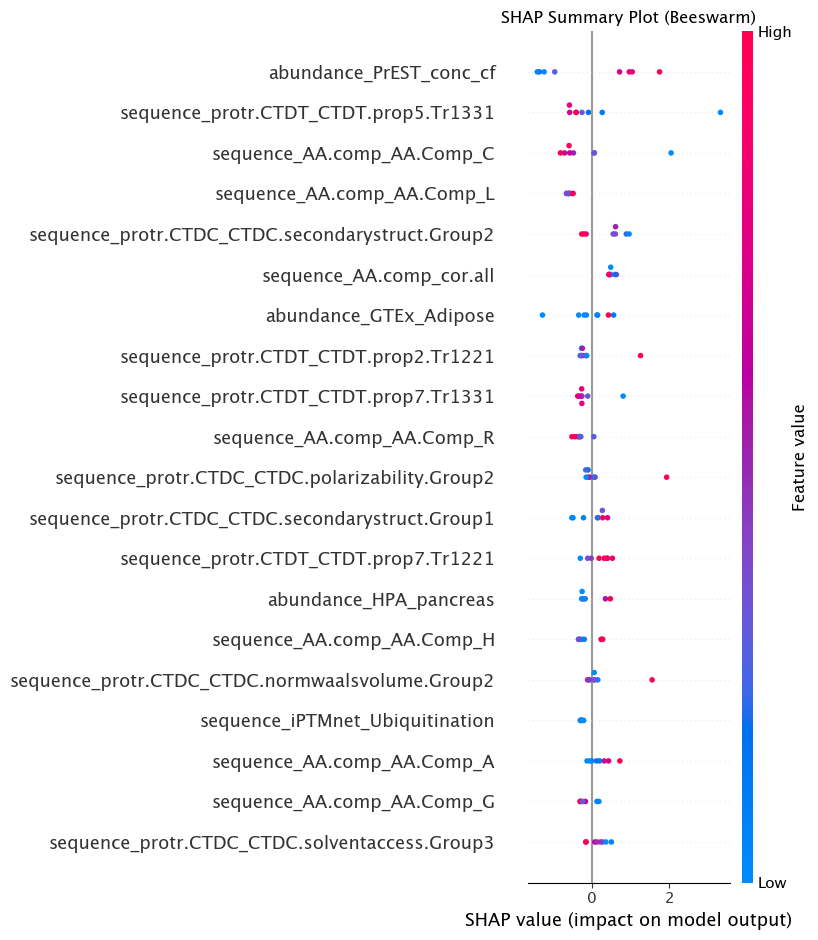

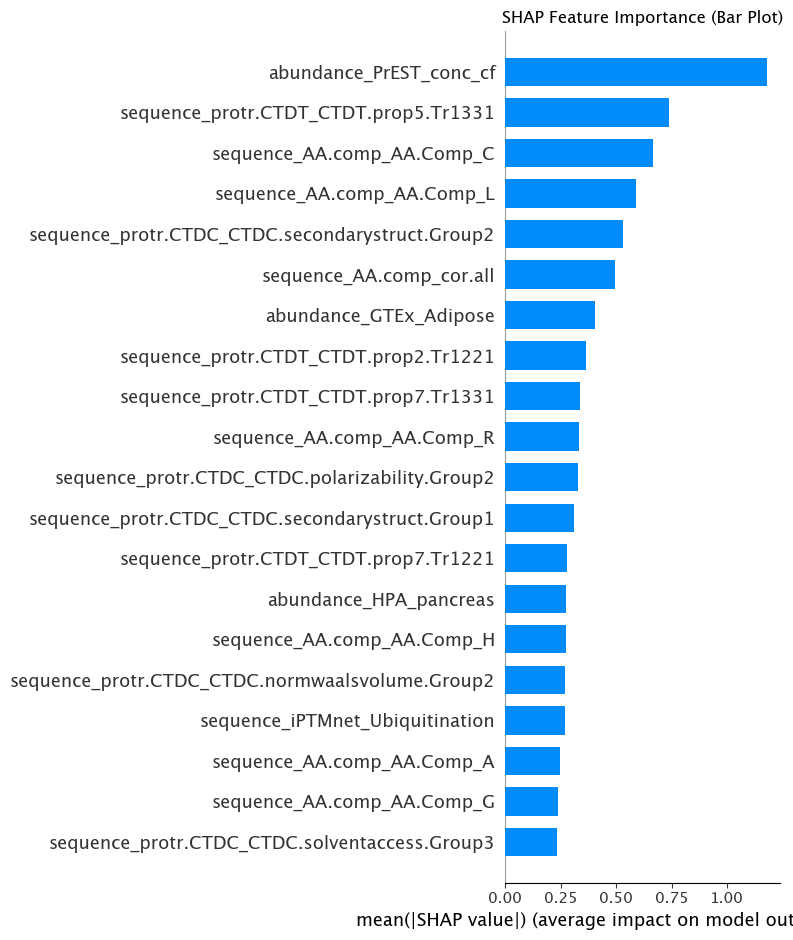

SHAP analysis complete. You can view the interactive force plot in 'results/shap_force_plot.html'.


In [28]:
#############################
# (5) SHAP Analysis
#############################

# Initialize JS visualization (optional, for interactive plots in notebooks)
shap.initjs()

# Create a TreeExplainer for the trained model
explainer = shap.TreeExplainer(model)

# Compute SHAP values on the test set (or you can choose a different subset)
shap_values = explainer.shap_values(X_test)

## (a) SHAP Beeswarm Summary Plot
plt.figure()
plt.title("SHAP Summary Plot (Beeswarm)")
shap.summary_plot(shap_values, X_test, feature_names=predictor_list)

## (b) SHAP Bar Plot of Mean |SHAP Value|
plt.figure()
plt.title("SHAP Feature Importance (Bar Plot)")
shap.summary_plot(shap_values, X_test, feature_names=predictor_list, plot_type="bar")


print("SHAP analysis complete. You can view the interactive force plot in 'results/shap_force_plot.html'.")

/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/ipykernel_4198/3030638021.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_features['Feature_mapped'] = top_features['Feature'].apply(map_feature_name)
/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/ipykernel_4198/3030638021.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_features['Color'] = top_features['Color'].apply(lambda x: positive_color if x == 'green' else negative_color)
/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/ipykernel_41

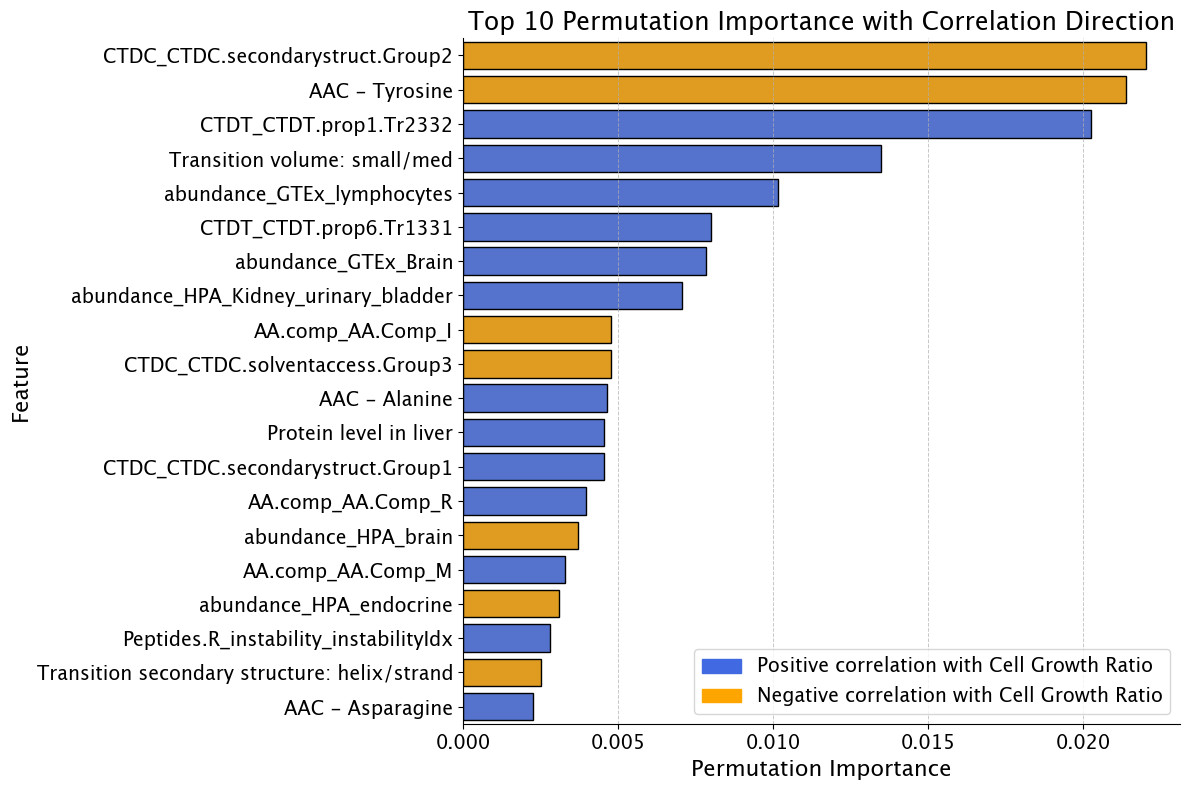

In [29]:
# --- Step 1: Compute Permutation Importance ---
# Calculate permutation importance on the test set.
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=1)

# Create a DataFrame for permutation importance.
perm_df = pd.DataFrame({
    'Feature': predictor_list,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

# --- Step 2: Compute Pearson Correlations ---
# Compute Pearson correlation coefficients between each feature and cell Cell Growth Ratio.
# full_df is the complete dataset (all splits combined) that contains the "Viability" column.
correlations = full_df[predictor_list + ['Cell Growth Ratio']].corr()['Cell Growth Ratio'].drop('Cell Growth Ratio')

# Add the correlation values to the permutation importance DataFrame.
perm_df['Correlation'] = perm_df['Feature'].map(correlations)

# --- Step 3: Create a Color Mapping Based on Correlation Sign ---
# Green for features positively correlated with Cell Growth Ratio; red for negatively correlated.
perm_df['Color'] = perm_df['Correlation'].apply(lambda x: 'green' if x > 0 else 'red')

# --- Step 4: Plot the Top 10 Features with a Custom Legend ---
# Subset to the top 10 most important features.
top_features = perm_df.head(20)

# --- Step 5: Define Mapping for Descriptive Feature Names ---
# The keys here are substrings expected in the cleaned feature names.
feature_mapping = {
    'CTDT_CTDT.prop2.Tr1331': 'Transition volume: small/large',
    'AA.comp_AA.Comp_W': 'AAC - Tryptophan',
    'Peptides.R_charge_charge': 'Protein charge',
    'AA.comp_AA.Comp_Q': 'AAC - Glutamine',
    'abundance_PrEST_conc_cf': 'Production yield in yeast',
    'CTDT_CTDT.prop7.Tr1331': 'Transition solvent accessibility: buried/intermediate',
    'abundance_HPA_pancreas': 'Protein level in pancreas',
    'CTDT_CTDT.prop6.Tr1221': 'Transition secondary structure: helix/strand',
    'PSIM_NG': 'N-linked glycosylation',
    'proStab_Tm.agg': 'Stability index',
    'AA.comp_AA.Comp_A': 'AAC - Alanine',
    'CTDT_CTDT.prop2.Tr1221': 'Transition volume: small/med',
    'AA.comp_AA.Comp_N': 'AAC - Asparagine',
    'CTDT_CTDT.prop4.Tr1221': 'Transition polarizability: low/med',
    'AA.comp_AA.Comp_Y': 'AAC - Tyrosine',
    'abundance_HPA_liver': 'Protein level in liver',
    'Peptides.R_aaComp.mole_NonPolar_Mole%': 'Percent nonpolar residues',
    'CTDT_CTDT.prop6.Tr2332': 'Transition secondary structure: strand/coil',
    'CTDC_CTDC.hydrophobicity.Group3': 'AA comp - hydrophobic residues',
    'CTDT_CTDT.prop7.Tr2332': 'Transition solvent accessibility: exposed/intermediate'
}

def map_feature_name(feature):
    # Remove the "sequence_" prefix.
    cleaned = feature.replace('sequence_', '')
    # Remove a leading "protr." if present.
    if cleaned.startswith("protr."):
        cleaned = cleaned[len("protr."):]
    # Check if any key from our mapping appears in the cleaned feature.
    for key, descriptive in feature_mapping.items():
        if key in cleaned:
            return descriptive
    # If no mapping is found, return the cleaned name.
    return cleaned

# Apply the mapping function.
top_features['Feature_mapped'] = top_features['Feature'].apply(map_feature_name)

# --- Step 6: Remap Colors to New Colors for Improved Aesthetics ---
positive_color = 'royalblue'  # For positive correlation.
negative_color = 'orange'     # For negative correlation.
top_features['Color'] = top_features['Color'].apply(lambda x: positive_color if x == 'green' else negative_color)

# --- Step 7: Plot with Custom Y-Axis Labels and Improved Aesthetics ---
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x='Importance', 
    y='Feature_mapped', 
    data=top_features, 
    palette=top_features['Color'].tolist(),
    edgecolor='black'
)

# Set title and labels with improved font sizes and bold styling.
ax.set_title("Top 10 Permutation Importance with Correlation Direction", fontsize=18, weight='bold')
ax.set_xlabel("Permutation Importance", fontsize=16)
ax.set_ylabel("Feature", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)

# Add a vertical grid for the x-axis.
ax.xaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.yaxis.grid(False)

# Remove the top and right spines.
sns.despine(ax=ax, top=True, right=True)

# Create custom legend patches.
positive_patch = mpatches.Patch(color=positive_color, label='Positive correlation with Cell Growth Ratio')
negative_patch = mpatches.Patch(color=negative_color, label='Negative correlation with Cell Growth Ratio')
plt.legend(handles=[positive_patch, negative_patch], loc='lower right', fontsize=14)

plt.savefig("results/permutation_importance_ML_reg.png", dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

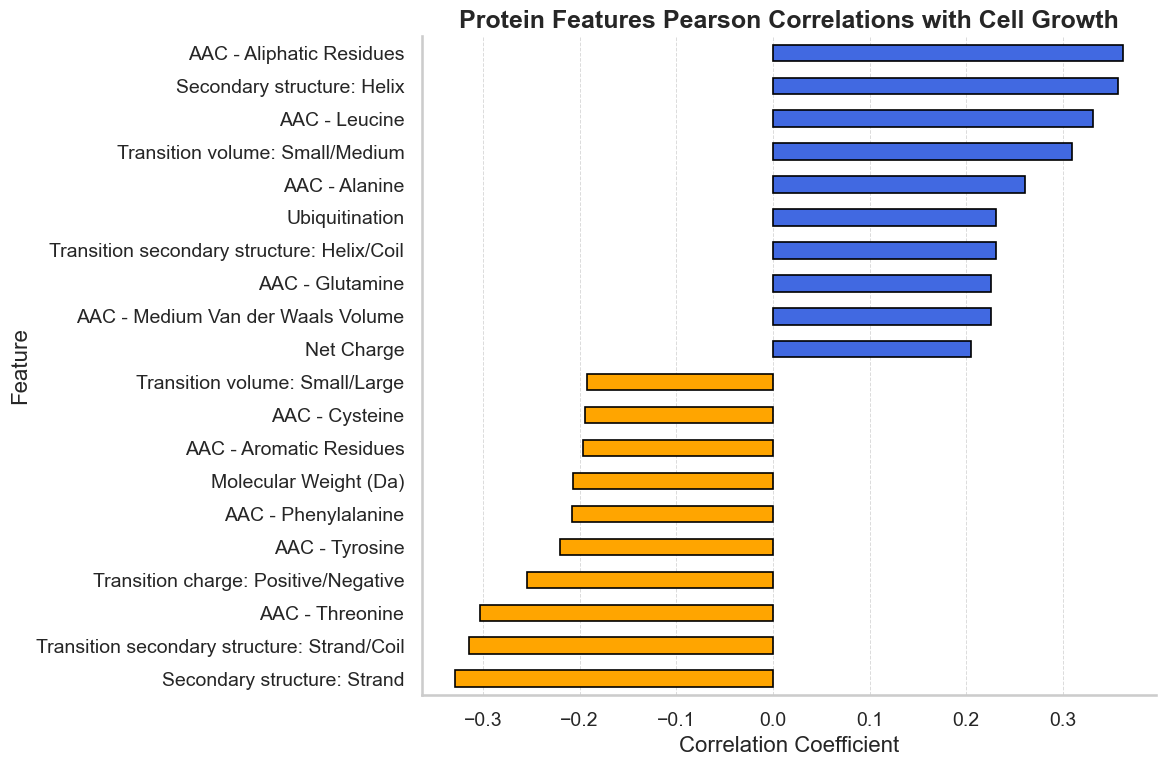

In [42]:
# Set a Seaborn theme for a clean and modern look.
sns.set_theme(style='whitegrid', context='talk')

# --- Step 1: Compute Pearson Correlations ---
# Calculate Pearson correlation coefficients between each feature and cell Cell Growth Ratio.
correlations = full_df[predictor_list + ['Cell Growth Ratio']].corr()['Cell Growth Ratio'].drop('Cell Growth Ratio')
correlations = correlations.dropna()
correlations = correlations.sort_values()

# --- Step 2: Subset the Top 10 Negative and Top 10 Positive Correlations ---
top10_negative = correlations.head(10)
top10_positive = correlations.tail(10)

# Combine the two subsets into one Series and sort again.
subset_correlations = pd.concat([top10_negative, top10_positive]).sort_values()

# --- Step 3: Map Feature Names to Descriptive Labels ---
# Define a mapping dictionary for your new features.
feature_mapping = {
    # Negative Correlations
    "CTDC_CTDC.secondarystruct.Group2": "Secondary structure: Strand",
    "CTDT_CTDT.prop6.Tr2332": "Transition secondary structure: Strand/Coil",
    "comp_AA.Comp_T": "AAC - Threonine",
    "CTDT_CTDT.prop5.Tr1331": "Transition charge: Positive/Negative",
    "comp_AA.Comp_Y": "AAC - Tyrosine",
    "comp_AA.Comp_F": "AAC - Phenylalanine",
    "Weight_MW..Da.": "Molecular Weight (Da)",
    "R_aaComp.mole_Aromatic_Mole%": "AAC - Aromatic Residues",
    "comp_AA.Comp_C": "AAC - Cysteine",
    "CTDT_CTDT.prop2.Tr1331": "Transition volume: Small/Large",
    "R_charge_charge": "Net Charge",
    "CTDC_CTDC.normwaalsvolume.Group2": "AAC - Medium Van der Waals Volume",
    "comp_AA.Comp_Q": "AAC - Glutamine",
    "CTDT_CTDT.prop6.Tr1331": "Transition secondary structure: Helix/Coil",
    "iPTMnet_Ubiquitination": "Ubiquitination",
    "comp_AA.Comp_A": "AAC - Alanine",
    "CTDT_CTDT.prop2.Tr1221": "Transition volume: Small/Medium",
    "comp_AA.Comp_L": "AAC - Leucine",
    "CTDC_CTDC.secondarystruct.Group1": "Secondary structure: Helix",
    "R_aaComp.mole_Aliphatic_Mole%": "AAC - Aliphatic Residues",
}

def map_feature_name(feature):
    # Remove the "sequence_" prefix if present.
    cleaned = feature.replace('sequence_', '')
    # Also remove a leading "protr." if present.
    if cleaned.startswith("protr."):
        cleaned = cleaned[len("protr."):]
    # Check if any mapping key is a substring of the cleaned feature name.
    for key, descriptive in feature_mapping.items():
        if key in cleaned:
            return descriptive
    # If no mapping is found, return the cleaned feature name.
    return cleaned

# The subset_correlations index contains the original feature names.
mapped_index = [map_feature_name(feat) for feat in subset_correlations.index]
subset_correlations.index = mapped_index

# --- Step 4: Define Colors and Update the Plot ---
# Define new colors: royalblue for positive correlations and orange for negative.
positive_color = 'royalblue'
negative_color = 'orange'
colors = [positive_color if val > 0 else negative_color for val in subset_correlations]

# --- Step 5: Plot the Correlation Analysis with Improved Aesthetics ---
plt.figure(figsize=(12, 8))
ax = subset_correlations.plot(kind='barh', color=colors, edgecolor='black', linewidth=1.2)
ax.set_title("Protein Features Pearson Correlations with Cell Growth", fontsize=18, weight='bold')
ax.set_xlabel("Correlation Coefficient", fontsize=16)
ax.set_ylabel("Feature", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.xaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.yaxis.grid(False)
sns.despine(ax=ax, top=True, right=True)

plt.savefig("results/corr_Cell Growth Ratio_protfeatures.svg", dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()